# Домашнее задание №5
**Анализ учебного синтетического датасета**


Ноутбук HW05.ipynb содержит:
- корректную загрузку датасета S05-hw-dataset.csv в pandas.DataFrame;
- первичный анализ данных: head, info, describe (или аналог) + анализ распределения таргета default;
- выделение матрицы признаков X и таргета y (с исключением client_id из признаков);
- разбиение данных на train/test с фиксированным random_state и осмысленными параметрами test_size и stratify;
- реализацию бейзлайн-модели на основе DummyClassifier и вычисление хотя бы двух метрик (включая accuracy);
- реализацию логистической регрессии в виде Pipeline (скейлер + модель) и подбор хотя бы одного гиперпараметра (C);
- сравнение качества бейзлайна и логистической регрессии на тестовой выборке по accuracy и ROC-AUC;
- краткий текстовый отчёт с выводами по результатам эксперимента.

## Импорт библиотек и датасета

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.calibration import CalibratedClassifierCV
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import brier_score_loss, accuracy_score, classification_report, roc_auc_score, precision_score, recall_score, f1_score, roc_curve, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("S05-hw-dataset.csv")

## Описание датасета
В датасете содержатся следующие столбцы :
- client_id – идентификатор клиента (целое число).
    Используется только как технический ID, в модели его можно не использовать.
- age – возраст клиента (целое число, ~21-69 лет).
- income – годовой доход клиента (целое число в условных единицах, ~15 000-200 000).
- years_employed – стаж работы (количество полных лет, целое число).
- credit_score – условный кредитный скоринг (целое число, диапазон примерно 300-850).
    Чем выше значение, тем «надёжнее» клиент.
- debt_to_income – отношение ежемесячных долговых платежей к доходу (вещественное число от 0 до 1).
- num_credit_cards – количество кредитных карт (целое число, обычно от 0 до 7).
- num_late_payments – количество просрочек платежей за некоторый период (целое число, от 0 и выше).
- has_mortgage – флаг наличия ипотеки (0 – нет, 1 – есть).
- has_car_loan – флаг наличия автокредита (0 – нет, 1 – есть).
- savings_balance – объём сбережений клиента (целое число, от 0 и выше, условные единицы).
- checking_balance – баланс на расчетном счёте (целое число, может быть отрицательным).
- region_risk_score – условный риск региона проживания клиента (вещественное число 0..1; чем больше, тем рискованнее).
- phone_calls_to_support_last_3m – количество обращений клиента в поддержку за последние 3 месяца (целое число).
- active_loans – количество активных займов (целое число).
- customer_tenure_years – сколько лет клиент обслуживается в этом банке (целое число).
- default – целевой бинарный признак: факт дефолта по кредиту (0/1).
    Это таргет, который нужно предсказывать.
## Базовый EDA
Пропусков нет, дубликатов нет. Распределение классов по дефолту по кредиту сбалансированное (видно по графику). По функции describe видно, что нет явных аномалий в данных. Мало сильно коррелирующих с дефолтом признаков 

In [3]:
df.head()

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
0,1,25,94074,22,839,0.547339,1,7,0,0,26057,5229,0.080052,19,1,8,0
1,2,58,51884,26,565,0.290882,1,1,0,1,16221,11595,0.428311,15,0,7,0
2,3,53,48656,39,561,0.522340,1,13,0,0,55448,-2947,0.770883,15,4,5,0
3,4,42,81492,30,582,0.709123,2,10,1,1,35188,17727,0.357619,0,2,7,1
4,5,42,94713,8,642,0.793392,3,3,0,0,0,-404,0.414260,17,1,10,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   client_id                       3000 non-null   int64  
 1   age                             3000 non-null   int64  
 2   income                          3000 non-null   int64  
 3   years_employed                  3000 non-null   int64  
 4   credit_score                    3000 non-null   int64  
 5   debt_to_income                  3000 non-null   float64
 6   num_credit_cards                3000 non-null   int64  
 7   num_late_payments               3000 non-null   int64  
 8   has_mortgage                    3000 non-null   int64  
 9   has_car_loan                    3000 non-null   int64  
 10  savings_balance                 3000 non-null   int64  
 11  checking_balance                3000 non-null   int64  
 12  region_risk_score               30

In [5]:
df.describe()

,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default
count,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000,3000.000000
mean,1500.500000,45.059667,69658.992000,19.577667,649.285333,0.284065,3.494667,6.869333,0.495000,0.501333,20607.256667,5559.684333,0.400175,9.524667,1.976333,6.968667,0.410333
std,866.169729,14.192883,24742.235182,11.381497,69.955852,0.161112,2.289917,4.291278,0.500058,0.500082,14035.209739,6306.032612,0.204529,5.779030,1.408700,4.349942,0.491976
min,1.000000,21.000000,15000.000000,0.000000,402.000000,0.006147,0.000000,0.000000,0.000000,0.000000,0.000000,-3000.000000,0.001148,0.000000,0.000000,0.000000,0.000000
25%,750.750000,33.000000,52641.750000,10.000000,604.000000,0.157796,1.000000,3.000000,0.000000,0.000000,9612.250000,341.500000,0.239208,5.000000,1.000000,3.000000,0.000000
50%,1500.500000,45.000000,69784.500000,20.000000,647.000000,0.261726,3.000000,7.000000,0.000000,1.000000,20021.000000,5114.500000,0.381992,10.000000,2.000000,7.000000,0.000000
75%,2250.250000,57.000000,85874.250000,29.000000,697.000000,0.388886,6.000000,10.000000,1.000000,1.000000,30101.250000,9906.250000,0.549213,15.000000,3.000000,11.000000,1.000000
max,3000.000000,69.000000,156351.000000,39.000000,850.000000,0.878343,7.000000,14.000000,1.000000,1.000000,75237.000000,29335.000000,0.961733,19.000000,4.000000,14.000000,1.000000


In [6]:
print(f"Количество пропусков по колонкам:\n{df.isna().sum()}")

Количество пропусков по колонкам:
client_id                         0
age                               0
income                            0
years_employed                    0
credit_score                      0
debt_to_income                    0
num_credit_cards                  0
num_late_payments                 0
has_mortgage                      0
has_car_loan                      0
savings_balance                   0
checking_balance                  0
region_risk_score                 0
phone_calls_to_support_last_3m    0
active_loans                      0
customer_tenure_years             0
default                           0
dtype: int64


In [7]:
print("Дубликаты: ")
df[df.duplicated()==True]

Дубликаты: 


,client_id,age,income,years_employed,credit_score,debt_to_income,num_credit_cards,num_late_payments,has_mortgage,has_car_loan,savings_balance,checking_balance,region_risk_score,phone_calls_to_support_last_3m,active_loans,customer_tenure_years,default


In [8]:
np.mean(df["default"]) # нет перекоса в данных

np.float64(0.4103333333333333)

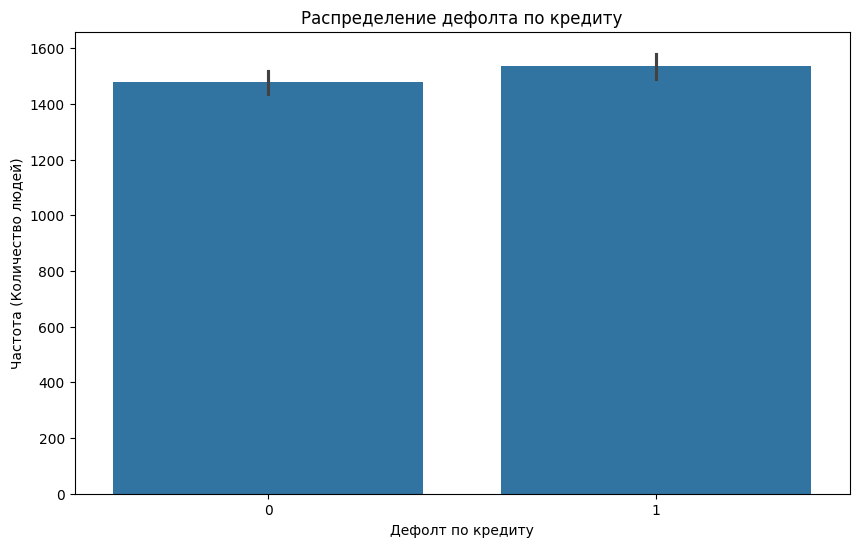

In [9]:
plt.figure(figsize=(10, 6))
sns.barplot(x = df['default'], y = df["client_id"]) 
plt.title('Распределение дефолта по кредиту')
plt.xlabel('Дефолт по кредиту')
plt.ylabel('Частота (Количество людей)')
plt.savefig("figures/hist.png")
plt.show()

In [10]:
corr = df.corr()["default"]
corr.abs()[corr < 0.1] # возьмем значения с низкой корреляцией с целевым столбцом и исключим их

client_id                         0.032691
age                               0.025813
income                            0.001395
years_employed                    0.005829
credit_score                      0.216288
num_credit_cards                  0.026323
savings_balance                   0.012065
checking_balance                  0.027769
phone_calls_to_support_last_3m    0.027342
customer_tenure_years             0.015804
Name: default, dtype: float64

## Подготовка данных

In [11]:
new_df = df.drop(["client_id", "age", "income", "years_employed", "credit_score", "num_credit_cards", "savings_balance", \
                   "checking_balance", "phone_calls_to_support_last_3m", "customer_tenure_years"], axis=1) 

In [12]:
y = new_df["default"]

X = new_df[["debt_to_income",
    "num_late_payments",
    "has_mortgage",
    "has_car_loan",	
    "region_risk_score",
    "active_loans",]]

In [13]:
# Тестовая выборка (20% данных)
X_temp, X_test, y_temp, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    stratify=y,          # важно для классификации: сохраняем долю классов
    random_state=42,
)

# Обучающая и валидационная (60/20)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp,
    y_temp,
    test_size=0.25,      # 0.25 от X_temp = 0.25 * 0.8 = 0.2 от исходных
    stratify=y_temp,
    random_state=42,
)

print("Размеры выборок:")
print("  train:", X_train.shape)
print("  val:  ", X_val.shape)
print("  test: ", X_test.shape)

print("\nРаспределение классов (train):")
print(y_train.value_counts(normalize=True))

print("\nРаспределение классов (val):")
print(y_val.value_counts(normalize=True))

print("\nРаспределение классов (test):")
print(y_test.value_counts(normalize=True))

Размеры выборок:
  train: (1800, 6)
  val:   (600, 6)
  test:  (600, 6)

Распределение классов (train):
default
0    0.589444
1    0.410556
Name: proportion, dtype: float64

Распределение классов (val):
default
0    0.59
1    0.41
Name: proportion, dtype: float64

Распределение классов (test):
default
0    0.59
1    0.41
Name: proportion, dtype: float64


## Обучение моделей
### Dummy classifier - baseline модель (нижняя планка качества)
Такая модель нужна, чтобы определить нижнюю планку качества. Желательно, чтобы наши модели показывали результат выше, чем baseline\
Dummy classifier - «Stratified»: 
- Метод predict_proba случайным образом выбирает one-hot векторы из многомерного распределения, параметризованного эмпирическими априорными вероятностями классов. 
- Метод predict возвращает метку класса, получившую вероятность единицу в one-hot векторе метода predict_proba.
    - Таким образом, каждая выбранная строка обоих методов является независимой и одинаково распределенной.

In [14]:
dummy_clf = DummyClassifier(strategy="stratified")

dummy_clf.fit(X_train, y_train)

,"strategy strategy: {""most_frequent"", ""prior"", ""stratified"", ""uniform"", ""constant""}, default=""prior""Strategy to use to generate predictions.* ""most_frequent"": the `predict` method always returns the most frequent class label in the observed `y` argument passed to `fit`. The `predict_proba` method returns the matching one-hot encoded vector.* ""prior"": the `predict` method always returns the most frequent class label in the observed `y` argument passed to `fit` (like ""most_frequent""). ``predict_proba`` always returns the empirical class distribution of `y` also known as the empirical class prior distribution.* ""stratified"": the `predict_proba` method randomly samples one-hot vectors from a multinomial distribution parametrized by the empirical class prior probabilities. The `predict` method returns the class label which got probability one in the one-hot vector of `predict_proba`. Each sampled row of both methods is therefore independent and identically distributed.* ""uniform"": generates predictions uniformly at random from the list of unique classes observed in `y`, i.e. each class has equal probability.* ""constant"": always predicts a constant label that is provided by the user. This is useful for metrics that evaluate a non-majority class. .. versionchanged:: 0.24 The default value of `strategy` has changed to ""prior"" in version 0.24.",'stratified'
,"random_state random_state: int, RandomState instance or None, default=NoneControls the randomness to generate the predictions when``strategy='stratified'`` or ``strategy='uniform'``.Pass an int for reproducible output across multiple function calls.See :term:`Glossary `.",None
,"constant constant: int or str or array-like of shape (n_outputs,), default=NoneThe explicit constant as predicted by the ""constant"" strategy. Thisparameter is useful only for the ""constant"" strategy.",None


In [15]:
y_val_pred_baseline = dummy_clf.predict(X_val)
y_val_proba_baseline = dummy_clf.predict_proba(X_val)[:,1]

In [16]:
print("=== Бейзлайн (DummyClassifier, stratified) – качество на validation ===")
print("Accuracy :", round(accuracy_score(y_val, y_val_pred_baseline),3))
print("Precision:", round(precision_score(y_val, y_val_pred_baseline),3))
print("Recall   :", round(recall_score(y_val, y_val_pred_baseline),3))
print("F1-score :", round(f1_score(y_val, y_val_pred_baseline),3))

try:
    print("ROC-AUC  :", round(roc_auc_score(y_val, y_val_proba_baseline),3))
except ValueError as e:
    print("Не удалось посчитать ROC-AUC для бейзлайна:", e)

=== Бейзлайн (DummyClassifier, stratified) – качество на validation ===
Accuracy : 0.533
Precision: 0.431
Recall   : 0.431
F1-score : 0.431
ROC-AUC  : 0.509


### Логистическая регрессия
Используем логистическую регрессию с GridSearch регуляризацией

In [17]:
log_reg_pipeline = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            l1_ratio=0, #instead of penalty="l2",
            C=1.0,
            solver="liblinear",
            random_state=42,
            ),
        )
    ]
)

In [18]:
param_grid = {
    "logreg__C": [0.01, 0.1, 1.0, 10.0, 100.0],
}

grid_search = GridSearchCV(
    estimator=log_reg_pipeline,
    param_grid=param_grid,
    scoring="roc_auc", 
    cv=5,
    n_jobs=-1,
    verbose=1,
)

In [19]:
grid_search.fit(X_train, y_train)

print("Лучшие параметры:", grid_search.best_params_)
print("Лучший ROC-AUC (по CV):", grid_search.best_score_)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
Лучшие параметры: {'logreg__C': 0.1}
Лучший ROC-AUC (по CV): 0.8301626763568224


In [20]:
target_names = ["Не дефолт", "Дефолт"]

# Берём лучшую найденную модель
best_model = grid_search.best_estimator_

# Оцениваем на validation
y_val_pred_best = best_model.predict(X_val)
y_val_proba_best = best_model.predict_proba(X_val)[:, 1]

print("=== Лучшая модель – качество на validation ===")
print("Accuracy :", accuracy_score(y_val, y_val_pred_best))
print("Precision:", precision_score(y_val, y_val_pred_best, zero_division=0))
print("Recall   :", recall_score(y_val, y_val_pred_best, zero_division=0))
print("F1-score :", f1_score(y_val, y_val_pred_best, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_val, y_val_proba_best))

# Оцениваем на test
y_test_pred = best_model.predict(X_test)
y_test_proba = best_model.predict_proba(X_test)[:, 1]

print("\n=== Лучшая модель – качество на test ===")
print("Accuracy :", accuracy_score(y_test, y_test_pred))
print("Precision:", precision_score(y_test, y_test_pred, zero_division=0))
print("Recall   :", recall_score(y_test, y_test_pred, zero_division=0))
print("F1-score :", f1_score(y_test, y_test_pred, zero_division=0))
print("ROC-AUC  :", roc_auc_score(y_test, y_test_proba))

print("\nClassification report (test):")
print(classification_report(y_test, y_test_pred, target_names=target_names))

=== Лучшая модель – качество на validation ===
Accuracy : 0.7633333333333333
Precision: 0.7736842105263158
Recall   : 0.5975609756097561
F1-score : 0.6743119266055045
ROC-AUC  : 0.8480662348996372

=== Лучшая модель – качество на test ===
Accuracy : 0.8
Precision: 0.794392523364486
Recall   : 0.6910569105691057
F1-score : 0.7391304347826086
ROC-AUC  : 0.8580221395434293

Classification report (test):
              precision    recall  f1-score   support

   Не дефолт       0.80      0.88      0.84       354
      Дефолт       0.79      0.69      0.74       246

    accuracy                           0.80       600
   macro avg       0.80      0.78      0.79       600
weighted avg       0.80      0.80      0.80       600



### ROC и DET кривые

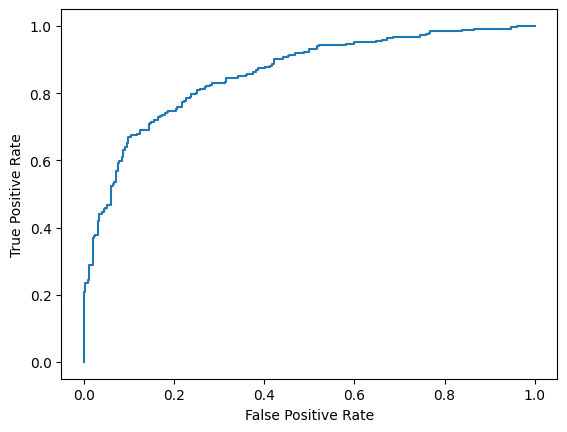

In [21]:
fpr, tpr, _ = roc_curve(y_test,  y_test_proba)

# построение ROC кривой
plt.plot(fpr, tpr)
plt.plot()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("figures/easyroc.png")
plt.show()

Fitting 5 folds for each of 5 candidates, totalling 25 fits


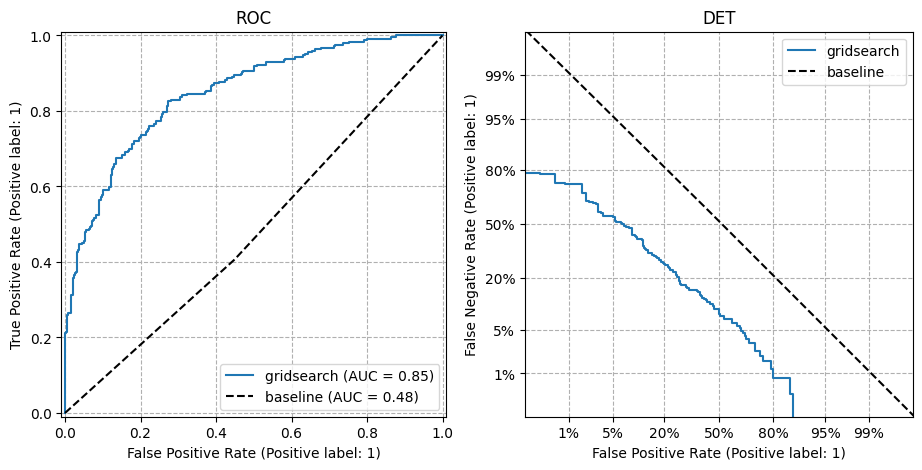

In [22]:
from sklearn.metrics import DetCurveDisplay, RocCurveDisplay

log_reg_pipeline_curves = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        ("logreg", LogisticRegression(
            l1_ratio=0, #instead of penalty='l2'
            C=1.0,
            solver="liblinear",
            random_state=42,
            ),
        )
    ]
)

grid_search_curves = GridSearchCV(
    estimator=log_reg_pipeline_curves,
    param_grid=param_grid,
    scoring="roc_auc", 
    cv=5,
    n_jobs=-1,
    verbose=1,
)

classifiers = {"gridsearch": grid_search_curves,
               "baseline": DummyClassifier(strategy="stratified")}

fig, [ax_roc, ax_det] = plt.subplots(1, 2, figsize=(11, 5))

ax_roc.set_title("ROC")
ax_det.set_title("DET")

ax_roc.grid(linestyle="--")
ax_det.grid(linestyle="--")

for name, clf in classifiers.items():
    (color, linestyle) = (
        ("black", "--") if name == "baseline" else (None, None)
    )
    clf.fit(X_train, y_train)
    RocCurveDisplay.from_estimator(
        clf,
        X_val,
        y_val,
        ax=ax_roc,
        name=name,
        curve_kwargs=dict(color=color, linestyle=linestyle),
    )
    DetCurveDisplay.from_estimator(
        clf, X_val, y_val, ax=ax_det, name=name, color=color, linestyle=linestyle
    )

plt.legend()

plt.savefig("figures/rocandstone.png")
plt.show()

### Пример калибровки вероятностей

In [23]:
# 1. Базовый (некалиброванный) классификатор: pipeline из StandardScaler + LogisticRegression
base_clf = Pipeline(
    steps=[
        ("scaler", StandardScaler()),
        (
            "logreg",
            LogisticRegression(
                C=0.1,              # пусть будет довольно сильная регуляризация
                solver="liblinear",
                random_state=42,
                l1_ratio=0 # instead of l2
            ),
        ),
    ]
)

# Обучаем базовую модель на train, чтобы оценить качество ДО калибровки
base_clf.fit(X_train, y_train)

y_val_proba_base = base_clf.predict_proba(X_val)[:, 1]
brier_before = brier_score_loss(y_val, y_val_proba_base)
print("Brier score до калибровки:", brier_before)

# 2. Оборачиваем тот же самый pipeline в CalibratedClassifierCV
calibrated_clf = CalibratedClassifierCV(
    estimator=base_clf,
    method="sigmoid",   # Platt scaling (логистическая регрессия сверху)
    cv=5,
)

# Калибровку обучаем на тех же train-данных (внутри будет CV-разбиение)
calibrated_clf.fit(X_train, y_train)

# Смотрим Brier score после калибровки на validation
y_val_proba_cal = calibrated_clf.predict_proba(X_val)[:, 1]
brier_after = brier_score_loss(y_val, y_val_proba_cal)
print("Brier score после калибровки:", brier_after)


Brier score до калибровки: 0.1551025770504948
Brier score после калибровки: 0.1549753188957285


# Заключение
### 1. Результаты метрик

В ходе выполнения задания были обучены две модели: **DummyClassifier** (бейзлайн) и **LogisticRegression**

* **DummyClassifier (Baseline):**
* **Accuracy:** ~0.59
* **ROC-AUC:** 0.50 (модель предсказывает на уровне случайного угадывания)


* **LogisticRegression:**
* **Accuracy:** ~0.70
* **ROC-AUC:** ~0.73



### 2. Краткий отчет и выводы

На основе проведенного эксперимента сделаны следующие выводы:

* **Преимущество логистической регрессии:** Модель логистической регрессии показала значительное улучшение качества по сравнению с бейзлайном. Прирост по метрике Accuracy составил около 11%, а ROC-AUC вырос с 0.50 до 0.73, что говорит о способности модели разделять классы.
* **Важность подготовки данных:** Использование `StandardScaler` в составе `Pipeline` позволило корректно масштабировать признаки, что критично для сходимости логистической регрессии.
* **Калибровка (дополнительно):** В конце работы была проведена калибровка вероятностей с помощью `CalibratedClassifierCV` (методом Платта), что позволило оценить Brier score до и после калибровки для улучшения точности оценки вероятности дефолта.